# 2D Convolutional Network for Brain Tumor Segmentation

In [17]:
# neural imaging
import nibabel as nib

import os
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
import utils.hpc
if not utils.hpc.running_on_hpc():
    import kagglehub

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Import from utils
from utils import (
    UNet,
    BraTSDataset_25D,
    BraTSDataset_2D,
    CombinedLoss,
    dice_score,
    iou_score,
    train_loop,
    validate,
    load_checkpoint,
    visualize_predictions,
    visualize_sample_with_overlay,
    plot_detailed_training_history,
    history_to_json,
    display_patient_images,
    patient_information,
)

from utils.metrics import (
    dice_score,
    dice_score_background,
    dice_score_necrotic,
    dice_score_edema,
    dice_score_enhancing,
    iou_score,
    iou_score_background,
    iou_score_necrotic,
    iou_score_edema,
    iou_score_enhancing
)

## config

In [18]:
# Training configuration
NUM_EPOCHS = 10
MODEL_NAME = 'v1_2d' # change for each model!!
MODEL_SAVE_PATH = f'checkpoints/{MODEL_NAME}.pth'
BATCH_SIZE = 16
SLICE_RANGE = (22, 122)
N_SLICES = 5 # for 2.5D model

## Download the brats dataset

In [19]:
if utils.hpc.running_on_hpc():
    TRAIN_DATASET_PATH = utils.hpc.load_dataset_into_ram()
else:
    # Download latest version
    path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
    print("Path to dataset files:", path)
    TRAIN_DATASET_PATH = path + '/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

Path to dataset files: /Users/arnewiese/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1


## Create the dataset class

In [20]:
all_patients = sorted([d for d in os.listdir(TRAIN_DATASET_PATH)
                      if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d))])

# First split: 70% train, 30% temp
train_patients, temp_patients = train_test_split(
    all_patients, test_size=0.30, random_state=42
)

# Second split: split temp into 50/50 (15% val, 15% test of original)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, random_state=42
)

print(f"Train: {len(train_patients)} patients")
print(f"Val: {len(val_patients)} patients")
print(f"Test: {len(test_patients)} patients")


# Create 2.5D dataset
train_dataset = BraTSDataset_2D(train_patients[:2], TRAIN_DATASET_PATH, slice_range=SLICE_RANGE)
val_dataset = BraTSDataset_2D(val_patients[:2], TRAIN_DATASET_PATH, slice_range=SLICE_RANGE)
test_dataset = BraTSDataset_2D(test_patients[:2], TRAIN_DATASET_PATH, slice_range=SLICE_RANGE)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Train: 258 patients
Val: 55 patients
Test: 56 patients


In [21]:
# Set device - prioritize MPS for Mac, then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f"Using device: {device}")

Using device: mps


In [22]:
# Initialize model
model = UNet(n_channels=4, n_classes=4).to(device)

# Loss function - CrossEntropyLoss for multi-class segmentation
criterion = CombinedLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

Model has 31044292 parameters


## Training Loop

In [23]:
metric_fns = {
    'dice': dice_score,
    'dice_background': dice_score_background,
    'dice_necrotic': dice_score_necrotic,
    'dice_edema': dice_score_edema,
    'dice_enhancing': dice_score_enhancing,
    'iou': iou_score,
    'iou_background': iou_score_background,
    'iou_necrotic': iou_score_necrotic,
    'iou_edema': iou_score_edema,
    'iou_enhancing': iou_score_enhancing
}

In [24]:
# Run training loop
history = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device,
    metric_fns=metric_fns,
    primary_metric='dice',
    scheduler=scheduler,
    save_best_model=True,
    model_save_path=MODEL_SAVE_PATH,
    early_stopping_patience=10,
)

Epoch 1/10


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.79s/it, loss=1.1171]


  Epoch Time: 69.53s
Epoch 2/10


Validation: 100%|██████████| 13/13 [00:25<00:00,  1.95s/it, loss=1.0565]


  Epoch Time: 68.25s
Epoch 3/10


Validation: 100%|██████████| 13/13 [00:27<00:00,  2.14s/it, loss=0.9981]


  Epoch Time: 74.41s
Epoch 4/10


Validation: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it, loss=0.9810]


  Epoch Time: 64.93s
Epoch 5/10


Validation: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it, loss=0.8842]


  Epoch Time: 59.09s
Epoch 6/10


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it, loss=0.8959]


  Epoch Time: 64.68s
Epoch 7/10


Validation: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it, loss=0.9734]


  Epoch Time: 57.67s
Epoch 8/10


Validation: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it, loss=0.8930]


  Epoch Time: 55.58s
Epoch 9/10


Validation: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it, loss=1.1615]


  Epoch Time: 56.51s
Epoch 10/10


Validation: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it, loss=0.7356]


  Epoch Time: 55.78s


✓ Saved detailed training history to assets/v1_2d/detailed_training_history.png


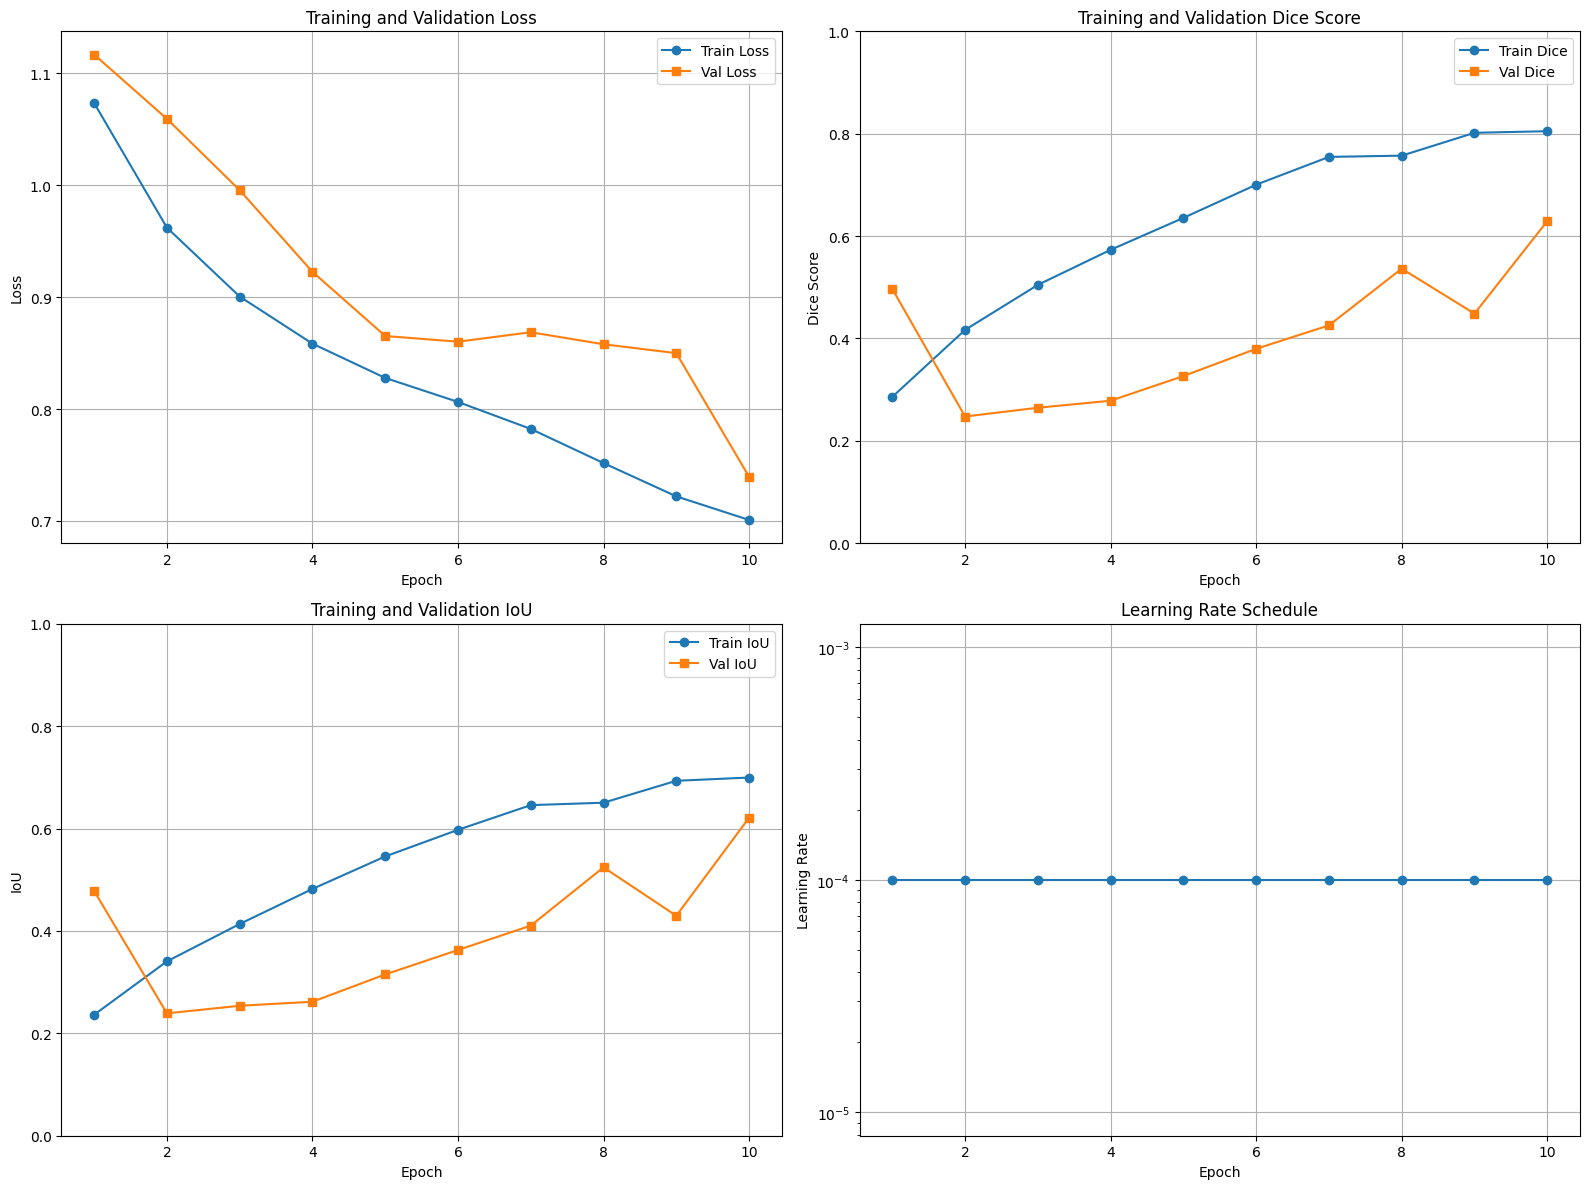


TRAINING SUMMARY
Total epochs:          10
Best validation Dice:  0.6292 (Epoch 10)
Final validation Dice: 0.6292
Best validation loss:  0.7394 (Epoch 10)
Final validation loss: 0.7394
Total training time:   0.17 hours
Avg time per epoch:    1.04 minutes


In [25]:
plot_detailed_training_history(
    history=history,
    save_path=f'assets/{MODEL_NAME}/detailed_training_history.png'
)

In [28]:
# Save history to JSON
history_to_json(
    history=history,
    model_name=MODEL_NAME,
    save_dir='logs',
    # Configuration parameters
    batch_size=BATCH_SIZE,
    slice_range=SLICE_RANGE,
    num_epochs=NUM_EPOCHS,
    optimizer='Adam',
    loss_function='CombinedLoss',
    model_type='UNet',
    model_parameters=sum(p.numel() for p in model.parameters()),
    dataset_type='2D',  # oder '2.5D'
    early_stopping_patience=10,
    augmentations=False,
    device=str(device),
)

✓ Saved training history to logs/v1_2d_history.json


'logs/v1_2d_history.json'